In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
import cv2

In [23]:
from sklearn.preprocessing import MinMaxScaler
# Folder path
import os

folder_path = "../data/sea"  # <-- replace with your actual folder path
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

# Desired size for all images (W x H)
target_size = (80, 80)  # Change this as needed

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]

print(f"Found {len(image_files)} image(s) in '{folder_path}'.")
# Store normalized images
normalized_images = []

track = 0

for filename in image_files:
    track = track +1
    if track > 50: 
        break
    img_path = os.path.join(folder_path, filename)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # read in grayscale (or use IMREAD_COLOR if needed)
    if image is None:
        print(f"Skipping {filename} (could not load).")
        continue

    image = cv2.resize(image, target_size)

    # --- Normalization logic ---
    original_shape = image.shape
    image_reshaped = image.reshape(-1, 1)  # Flatten to (num_pixels, 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_image_reshaped = scaler.fit_transform(image_reshaped)
    
    normalized_image = normalized_image_reshaped.reshape(original_shape)
    normalized_images.append(normalized_image)

print(f"Normalized {len(normalized_images)} image(s)'.")

Found 2274 image(s) in '../data/sea'.
Normalized 50 image(s)'.


In [24]:
images = np.array(normalized_images)
n_samples, h, w = images.shape
print(f"Loaded {n_samples} normalized images of size {h}x{w}")

# Flatten each image into a single row → (n_samples, n_pixels)
X = images.reshape(n_samples, -1)
print(f"Image matrix shape: {X.shape} (rows=samples, cols=pixels)")

Loaded 50 normalized images of size 80x80
Image matrix shape: (50, 6400) (rows=samples, cols=pixels)


In [25]:
mean_image = np.mean(X, axis=0)
X_centered = X - mean_image
print("Data centered by subtracting mean image.")


Data centered by subtracting mean image.


In [26]:
cov_matrix = np.cov(X_centered, rowvar=False)
print(f"Covariance matrix shape: {cov_matrix.shape}")

Covariance matrix shape: (6400, 6400)


In [27]:
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
# Sort descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
print("Eigen decomposition complete and sorted by variance.")

Eigen decomposition complete and sorted by variance.


In [28]:
def project_data(X_centered, eigvecs, k):
    components = eigvecs[:, :k]
    X_proj = np.dot(X_centered, components)
    return X_proj, components

def reconstruct_data(X_proj, components, mean_image):
    X_rec = np.dot(X_proj, components.T) + mean_image
    return X_rec

def mse(X, X_rec):
    return np.mean((X - X_rec) ** 2)

In [29]:
ks = [1, 5, 10, 20, 30, 40, 50, min(100, X.shape[1])]
mse_values = []

for k in ks:
    X_proj, comps = project_data(X_centered, eigvecs, k)
    X_rec = reconstruct_data(X_proj, comps, mean_image)
    err = mse(X, X_rec)
    mse_values.append(err)
    print(f"k = {k:3d} → Mean Squared Error = {err:.6f}")

k =   1 → Mean Squared Error = 0.038817
k =   5 → Mean Squared Error = 0.018572
k =  10 → Mean Squared Error = 0.012360
k =  20 → Mean Squared Error = 0.006441
k =  30 → Mean Squared Error = 0.003038
k =  40 → Mean Squared Error = 0.000987
k =  50 → Mean Squared Error = 0.000000
k = 100 → Mean Squared Error = 0.000000


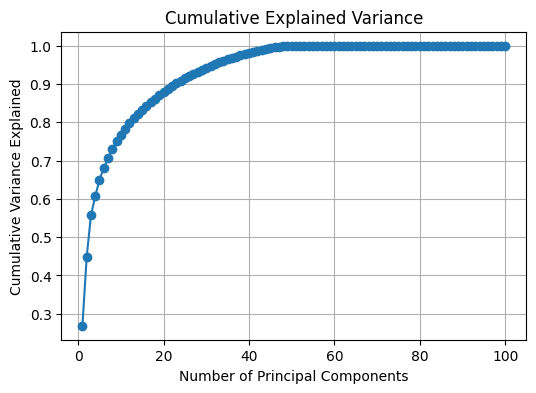

In [30]:
explained_variance_ratio = eigvals / np.sum(eigvals)
cumulative_variance = np.cumsum(explained_variance_ratio)
ks_to_show = [1, 5, 10, 20, 40, 50, min(100, X.shape[1])]

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, 50+1), cumulative_variance[:50], marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

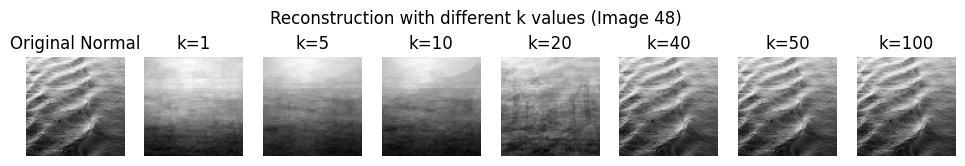

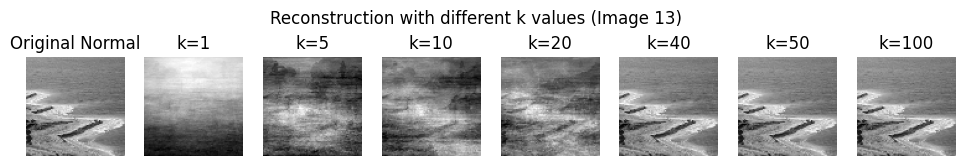

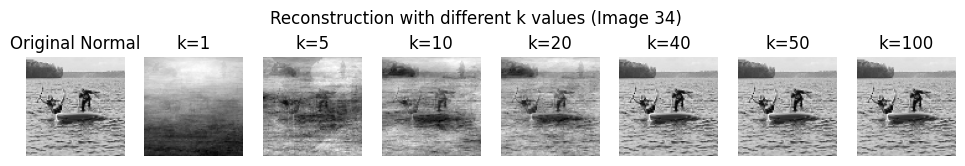

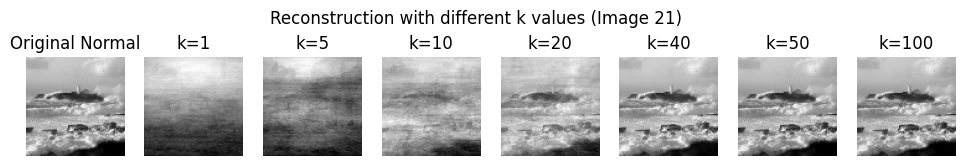

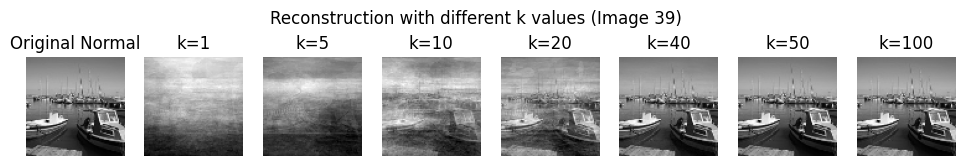

In [31]:
num_display = min(5, n_samples)
sample_indices = np.random.choice(n_samples, num_display, replace=False)

for idx in sample_indices:
    plt.figure(figsize=(12, 2))
    plt.subplot(1, len(ks_to_show) + 1, 1)
    plt.imshow(X[idx].reshape(h, w), cmap='gray')
    plt.title("Original Normal")
    plt.axis('off')
    
    for j, k in enumerate(ks_to_show):
        X_proj, comps = project_data(X_centered, eigvecs, k)
        X_rec = reconstruct_data(X_proj, comps, mean_image)
        plt.subplot(1, len(ks_to_show) + 1, j + 2)
        plt.imshow(X_rec[idx].reshape(h, w), cmap='gray')
        plt.title(f"k={k}")
        plt.axis('off')

    plt.suptitle(f"Reconstruction with different k values (Image {idx})")
    plt.show()

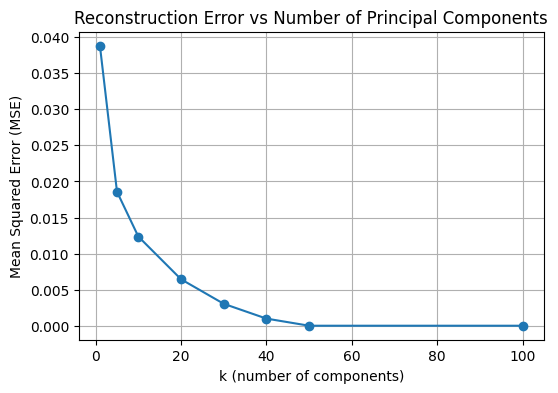

In [32]:
plt.figure(figsize=(6,4))
plt.plot(ks, mse_values, 'o-')
plt.title("Reconstruction Error vs Number of Principal Components")
plt.xlabel("k (number of components)")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

In [33]:
k_90 = np.searchsorted(cumulative_variance, 0.90) + 1
print("\n--- PCA Summary ---")
print(f"Total components available: {X.shape[1]}")
print(f"Components needed for 90% variance: {k_90}")
print("As k increases:")
print("- Reconstruction quality improves.")
print("- MSE decreases.")
print("- Compression ratio decreases.")
print("Use cumulative variance and MSE curve to choose an optimal k that balances quality and efficiency.")


--- PCA Summary ---
Total components available: 6400
Components needed for 90% variance: 23
As k increases:
- Reconstruction quality improves.
- MSE decreases.
- Compression ratio decreases.
Use cumulative variance and MSE curve to choose an optimal k that balances quality and efficiency.
